In [15]:
#import os
import sys
sys.path.append("../python/")
from helpers import *
#import pickle
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr
from itertools import combinations
from scipy.stats import ttest_ind, f_oneway # for independent t-test

In [58]:
SENSITIVITY_RESULTS_DIR = '../../results/sensitivity-tests-07272021' #'../../results/sensitivity-tests-02272021'
SCENARIO_LIST = ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]
IMAGE_WIDTH_LIST = [189, 252, 336]

In [44]:
def getPerformanceDataFrame():
    result_file_list = getListOfFiles(SENSITIVITY_RESULTS_DIR)
    df = pd.DataFrame()
    for filename in result_file_list:
        if "scenario-resolution-" in filename:
            performance_dict = json.load(open(filename))
            performance_df = pd.DataFrame(performance_dict["metrics"])
            performance_df['epoch'] = performance_df.index + 1
            performance_df["width"] = performance_dict["image_width"]
            performance_df["height"] = performance_dict["image_height"]
            performance_df["scenario"] = performance_dict["scenario"]
            #performance_df["best_val_accuracy"] = performance_dict["best_val_accuracy"]
            performance_df["trial"] = int(filename.split("-")[-1].split(".")[0])
            df = df.append(performance_df, ignore_index=True)    
    return(df)

In [55]:
def getScenarioResolutionMeanPerformance():
    dp = getPerformanceDataFrame()
    #print(dp.head())
    #dpagg = dp.groupby(['scenario','width', 'height','trial','epoch']).agg('max')
    df = dp.loc[dp.groupby(['scenario','width', 'height', 'trial'])['val_accuracy'].idxmax()]
    print(df.head())
    df = df.iloc[:,[3, 4, 5, 6, 8, 10]]  #val_accuracy 	val_f1 	val_recall 	val_precision scenario
    df = df.groupby(['scenario','width']).agg(['mean','std'])
    df = np.round(df, 2)
    df = df.reindex(index=["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"], level=0)
    df.to_csv('../../results/scenario-resolution-best-mean-std-performance.csv')    
    return df

In [56]:
getScenarioResolutionMeanPerformance()

          loss  accuracy  val_loss  val_accuracy    val_f1  val_recall  \
1109  0.073563  0.992949  0.616422      0.704225  0.479258    0.531076   
16    0.009051  1.000000  0.734466      0.718310  0.607975    0.603896   
487   0.083390  0.985899  0.603813      0.699531  0.497790    0.536024   
360   0.693045  0.593419  0.659988      0.690141  0.408333    0.500000   
601   0.566706  0.710094  0.683498      0.693396  0.437436    0.511727   

      val_precision  epoch  width  height scenario  trial  
1109       0.709085     10    189     189  PrPo_Im      1  
16         0.665626     17    189     189  PrPo_Im      2  
487        0.644900      8    189     189  PrPo_Im      3  
360        0.345070      1    189     189  PrPo_Im      4  
601        0.680223      2    189     189  PrPo_Im      5  


val_accuracy       val_f1       val_recall       val_precision  \
                       mean   std   mean   std       mean   std          mean   
scenario width                                                                  
Pr_Im    189           0.86  0.00   0.48  0.02       0.51  0.01          0.63   
         252           0.86  0.00   0.48  0.03       0.51  0.02          0.50   
         336           0.86  0.00   0.46  0.00       0.50  0.00          0.43   
PrPo_Im  189           0.70  0.01   0.49  0.08       0.54  0.04          0.61   
         252           0.71  0.01   0.52  0.05       0.55  0.03          0.71   
         336           0.69  0.00   0.42  0.02       0.51  0.01          0.62   
Pr_PoIm  189           0.89  0.00   0.47  0.00       0.50  0.00          0.44   
         252           0.89  0.00   0.48  0.03       0.51  0.02          0.49   
         336           0.89  0.01   0.50  0.04       0.51  0.02          0.58   
Pr_Po_Im 189           0.69  0.00   0.30  0.04       0.35  0.02          0.39   
         252           0.70  0.00   0.32  0.05       0.36  0.03          0.50   
         336           0.69  0.00   0.27  0.00       0.33  0.00          0.23   

                      
                 std  
scenario width        
Pr_Im    189    0.28  
         252    0.15  
         336    0.00  
PrPo_Im  189    0.15  
         252    0.09  
         336    0.26  
Pr_PoIm  189    0.00  
         252    0.11  
         336    0.22  
Pr_Po_Im 189    0.16  
         252    0.08  
         336    0.00

In [392]:
print([c for c in combinations([64, 128, 224], 2)])

[(64, 128), (64, 224), (128, 224)]


In [158]:
print([ comb for comb in combinations(["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"], 2)])

[('Pr_Im', 'PrPo_Im'), ('Pr_Im', 'Pr_PoIm'), ('Pr_Im', 'Pr_Po_Im'), ('PrPo_Im', 'Pr_PoIm'), ('PrPo_Im', 'Pr_Po_Im'), ('Pr_PoIm', 'Pr_Po_Im')]


In [387]:
df = dp.loc[dp.groupby(['scenario','resolution','trial'])['val_accuracy'].idxmax()]
dpagg = df.set_index(['scenario','resolution','trial'])
dpmax = dpagg.iloc[:,3:7]

In [65]:
def resolutionPerformanceComparisonStats():
    dp = getPerformanceDataFrame()
    df = dp.loc[dp.groupby(['scenario','width','trial'])['val_accuracy'].idxmax()]
    dpagg = df.set_index(['scenario','width','trial'])
    print(dpagg.head())
    dpmax = dpagg.iloc[:,3:7]
    dstats = pd.DataFrame(columns= ['Scenario', 'Resolution 1', 'Resolution 2',  'Accuracy', 'F1', 'Recall', 'Precision'])
    rowcounter = 0
    for i in SCENARIO_LIST:
        for j in combinations(IMAGE_WIDTH_LIST, 2):
            dstats.loc[rowcounter, ['Scenario', 'Resolution 1', 'Resolution 2'] ] = (i, j[0], j[1])
            tstats, pvals = ttest_ind(dpmax.loc[(i, j[0])], dpmax.loc[(i, j[1])], equal_var=False) 
            dstats.loc[rowcounter, ['Accuracy', 'F1', 'Recall', 'Precision']] = pvals
            rowcounter += 1
    dstats.to_csv('../../results/resolution-performance-comparison-stats.csv', index=False)
    print(dstats.head())
    return dstats
resolutionPerformanceComparisonStats()

                          loss  accuracy  val_loss  val_accuracy    val_f1  \
scenario width trial                                                         
PrPo_Im  189   1      0.073563  0.992949  0.616422      0.704225  0.479258   
               2      0.009051  1.000000  0.734466      0.718310  0.607975   
               3      0.083390  0.985899  0.603813      0.699531  0.497790   
               4      0.693045  0.593419  0.659988      0.690141  0.408333   
               5      0.566706  0.710094  0.683498      0.693396  0.437436   

                      val_recall  val_precision  epoch  height  
scenario width trial                                            
PrPo_Im  189   1        0.531076       0.709085     10     189  
               2        0.603896       0.665626     17     189  
               3        0.536024       0.644900      8     189  
               4        0.500000       0.345070      1     189  
               5        0.511727       0.680223      2     189 

,Scenario,Resolution 1,Resolution 2,Accuracy,F1,Recall,Precision
0,Pr_Im,189,252,0.507465,0.935308,0.94271,0.377395
1,Pr_Im,189,336,0.155487,0.176827,0.177808,0.177668
2,Pr_Im,252,336,0.311922,0.372538,0.373901,0.373377
3,PrPo_Im,189,252,0.411203,0.383844,0.444651,0.243051
4,PrPo_Im,189,336,0.213436,0.142798,0.17724,0.92842
5,PrPo_Im,252,336,0.068783,0.009516,0.011694,0.505679
6,Pr_PoIm,189,252,1.0,0.374127,0.373901,0.374014
7,Pr_PoIm,189,336,0.582176,0.211606,0.21696,0.239652
8,Pr_PoIm,252,336,0.582176,0.626858,0.611548,0.474117
9,Pr_Po_Im,189,252,0.388338,0.441716,0.408312,0.201752


In [74]:
def scenarioPerformanceComparisonStats():
    dp = getPerformanceDataFrame()
    df = dp.loc[dp.groupby(['scenario','width','trial'])['val_accuracy'].idxmax()]
    dpagg = df.set_index(['scenario','width','trial'])
    dpmax = dpagg.iloc[:,3:7]
    dstats = pd.DataFrame(columns= ['Resolution', 'Scenario 1', 'Scenario 2',  'Accuracy', 'F1', 'Recall', 'Precision'])
    rowcounter = 0
    #print(dstats)
    for i in IMAGE_WIDTH_LIST:
        for j in combinations(SCENARIO_LIST, 2):
            dstats.loc[rowcounter, ['Resolution', 'Scenario 1', 'Scenario 2'] ] = (i, j[0], j[1])
            tstats, pvals = ttest_ind(dpmax.loc[(j[0], i)], dpmax.loc[(j[1], i)], equal_var=False)# ,dpmax.loc[("Pr_PoIm", 64)],dpmax.loc[("Pr_Po_Im", 64)]) 
            #print(pvals)
            #print([i, j[0], j[1]])#.append(pvals))
            dstats.loc[rowcounter, ['Accuracy', 'F1', 'Recall', 'Precision']] = pvals
            #dstats = dstats.append( pd.DataFrame({[i, j[0], j[1]].extend(pvals)}), ignore_index=True)
            rowcounter += 1
    dstats.to_csv('../../results/scenario-performance-comparison-stats.csv', index=False)
    return(dstats)
scenarioPerformanceComparisonStats()


,Resolution,Scenario 1,Scenario 2,Accuracy,F1,Recall,Precision
0,189,Pr_Im,PrPo_Im,0.000002,0.845406,0.197444,0.881371
1,189,Pr_Im,Pr_PoIm,0.000042,0.439603,0.177808,0.202912
2,189,Pr_Im,Pr_Po_Im,0.0,0.000041,0.000001,0.13788
3,189,PrPo_Im,Pr_PoIm,0.000003,0.663898,0.112937,0.06853
4,189,PrPo_Im,Pr_Po_Im,0.211162,0.003187,0.000123,0.053705
5,189,Pr_PoIm,Pr_Po_Im,0.0,0.000459,0.000044,0.489767
6,252,Pr_Im,PrPo_Im,0.000007,0.132361,0.011586,0.033119
7,252,Pr_Im,Pr_PoIm,0.000011,0.74147,0.97266,0.972583
8,252,Pr_Im,Pr_Po_Im,0.0,0.000467,0.00004,0.937067
9,252,PrPo_Im,Pr_PoIm,0.000006,0.18601,0.010878,0.011349


In [91]:
def plotMeanAccuracyLoss():
    df = getPerformanceDataFrame()
    #df = df[df.epoch <16]
    melted_df = df.melt(id_vars = ["epoch", "width", "scenario", "trial"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy"], var_name = "metric", value_name = "value")
    melted_df["type"] = None
    melted_df.loc[melted_df.metric.isin(["loss", "val_loss"]), "type"] = "Loss"
    melted_df.loc[melted_df.metric.isin(["accuracy", "val_accuracy"]), "type"] = "Accuracy"
    print(melted_df.head())
    num_scenarios = len(df.scenario.unique())
    num_resolutions = len(df.width.unique())
    num_epochs = df.epoch.max()
    sns.set_style("whitegrid")
    g = sns.FacetGrid(melted_df, col="scenario", row="type", sharey = False, col_order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"])
    g.map_dataframe(sns.lineplot, x = "epoch", y = "value", style = "metric",# style_order = ['Validation','Training'], 
                    hue = "width",# estimator=None, units='trial',
                    palette= sns.color_palette("Set1", n_colors=num_resolutions),
                   alpha=1)
    g.set_axis_labels("Epoch", "",  fontsize=14)
    g.add_legend( fontsize=16) 
    ## Customize legend
    g._legend.texts[0].set_text("Resolution")
    g._legend.texts[num_resolutions + 1].set_text("Phase") #Data
    g._legend.texts[num_resolutions + 2].set_text("Training")
    g._legend.texts[num_resolutions + 3].set_text("Validation")    
    g._legend.texts[num_resolutions + 4].set_text("")    
    g._legend.texts[num_resolutions + 5].set_text("")    
    g._legend.legendHandles[num_resolutions + 4].set_linewidth(0)
    g._legend.legendHandles[num_resolutions + 5].set_linewidth(0)    
    g._legend._legend_box.sep = 5
    axes = g.axes
    for row, axlist in enumerate(axes):
        if row==0:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0, 2.25)#.75 
                axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].xaxis.set_major_locator(tkr.AutoLocator())
                axes[row, col].set_title("Scenario: " + 
                                         str(axes[row, col].title).split("scenario = ")[1].split(")")[0].split("\'")[0], fontsize=16)
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Loss", fontsize=14)
        elif row==1:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0.4, 1)
                axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].set_title("")
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Accuracy", fontsize=14)
    g.savefig("../../figures/scenario_resolution_performance.png", dpi=180)
    return(g)

   epoch  width scenario  trial metric     value  type
0      1    189  PrPo_Im      2   loss  0.691619  Loss
1      2    189  PrPo_Im      2   loss  0.621129  Loss
2      3    189  PrPo_Im      2   loss  0.547470  Loss
3      4    189  PrPo_Im      2   loss  0.489042  Loss
4      5    189  PrPo_Im      2   loss  0.417867  Loss


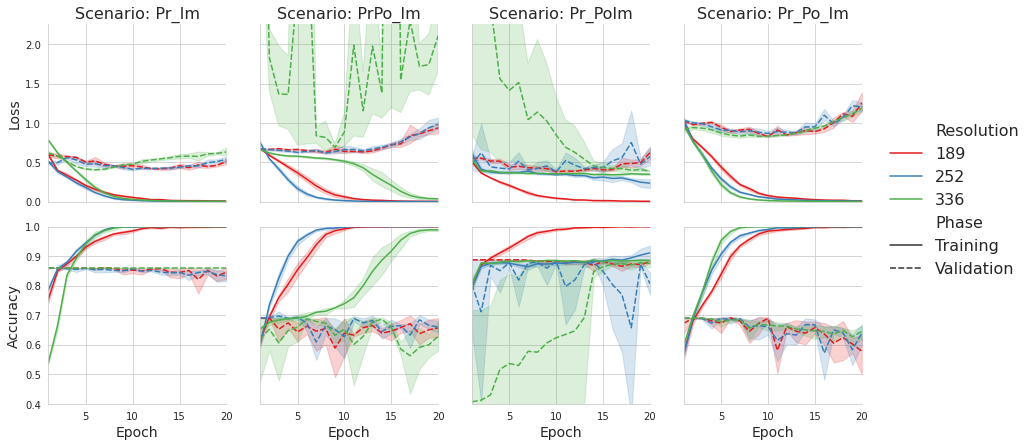

In [92]:
gg = plotMeanAccuracyLoss()

In [226]:
def testMeanValidationAccuracy():
    df = getPerformanceDataFrame()
    
    df = df[['scenario', "resolution", "trial", 'best_val_accuracy']].drop_duplicates()
    #df1['resolution'] = df1['resolution'].map(str)
    df = df.melt(id_vars = ['scenario', "resolution", "trial"], value_vars = ["best_val_accuracy"], var_name = "metric", value_name = "value")
    
    dfacc = df.groupby(["scenario", "resolution"]).mean()
    dfacc = dfacc.drop(["trial"], axis = 1)
    dfacc.columns = ['mean']
    dfacc['stdev'] = df.groupby(["scenario", "resolution"]).std()['value']
    print(np.round(dfacc,2))
    for s in SCENARIO_LIST:
        print(s)
        dfs = df[df.scenario==s]
        print("Test difference between resolutions 64 and 128")
        print(ttest_ind(dfs.loc[dfs.resolution==64,'value'], dfs.loc[dfs.resolution==128,'value'], equal_var=False))
        print("Test difference between resolutions 64 and 224")
        print(ttest_ind(dfs.loc[dfs.resolution==64,'value'], dfs.loc[dfs.resolution==224,'value'], equal_var=False))    
    return
testMeanValidationAccuracy()

                     mean  stdev
scenario resolution             
PrPo_Im  64          0.96   0.04
         128         0.96   0.05
         224         0.96   0.05
Pr_Im    64          0.98   0.03
         128         0.97   0.03
         224         0.97   0.03
Pr_PoIm  64          0.96   0.04
         128         0.97   0.04
         224         0.97   0.04
Pr_Po_Im 64          0.94   0.07
         128         0.95   0.07
         224         0.95   0.06
Pr_Im
Test difference between resolutions 64 and 128
Ttest_indResult(statistic=0.01976319227745044, pvalue=0.9844497250404811)
Test difference between resolutions 64 and 224
Ttest_indResult(statistic=0.24360063513619826, pvalue=0.8103062006606452)
PrPo_Im
Test difference between resolutions 64 and 128
Ttest_indResult(statistic=0.12736637270221182, pvalue=0.9000692161378825)
Test difference between resolutions 64 and 224
Ttest_indResult(statistic=0.06680323542374512, pvalue=0.9474847347557567)
Pr_PoIm
Test difference between resoluti

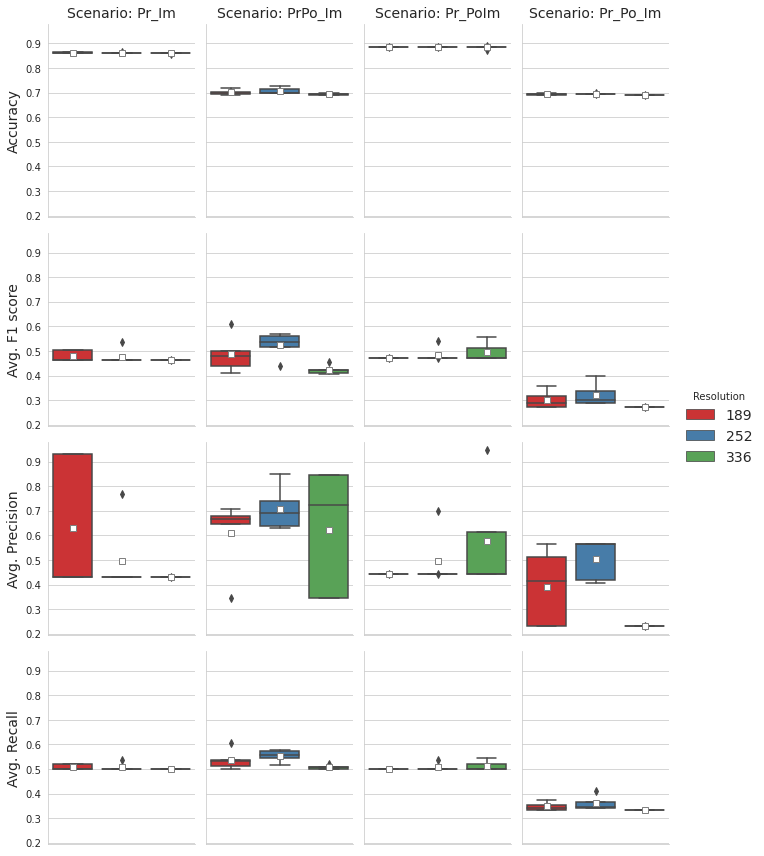

In [95]:
def plotSummaryValidationMetrics(type="box", facet=True, metrics="performance"):
    dp = getPerformanceDataFrame()    
    df = dp.loc[dp.groupby(['scenario','width','trial'])['val_accuracy'].idxmax()]
    num_resolutions = len(dp.width.unique())
    df.width = df.width.astype(object)
    if metrics=="performance":
        value_variables = ["val_accuracy", "val_f1", "val_precision", "val_recall"]
        row_labels = ["Accuracy", "Avg. F1 score", "Avg. Precision", "Avg. Recall"]
    else:
        value_variables = ["val_loss", "val_accuracy", "val_f1", "val_precision", "val_recall"]
        row_labels = ["Loss", "Accuracy", "Avg. F1 score", "Avg. Precision", "Avg. Recall"]
    #df = df[['scenario', "width", "trial", 'best_val_accuracy']].drop_duplicates()
    df = df.melt(id_vars = ['scenario','width','trial'], value_vars = value_variables,  var_name = "metric", value_name = "value")  
    #df = df.melt(id_vars = ['scenario', "width", "trial"], value_vars = [metric], var_name = "metric", value_name = "value")    
    if facet==True:
        g = sns.FacetGrid(df, col="scenario", row = "metric", sharey = True,  col_order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"], aspect=.8)
        if type=="box":
            g.map_dataframe(sns.boxplot, x = "width", y = "value", hue = "width", 
                        palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge = False,
                        showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"})#, capsize = .2, errwidth=1.2)
            #g.set(ylim =(.4,1))
            g.add_legend(fontsize=14, title="Resolution", title_fontsize=14)#,bbox_to_anchor=(.9, .6), loc=2 )#, labels = row_labels) 
            #g._legend(title_fontsize=18)
        elif type=="point":
            g.map_dataframe(sns.pointplot, x = "width", y = "value",  capsize = .2, errwidth=1.2)
            g.set(ylim =(.89,1.0))       
        g.set_xticklabels([])
        #g.set_axis_labels("Resolution", "Validation Accuracy")
        axes = g.axes
        for row, axlist in enumerate(axes):
            for col, axis in enumerate(axes[row]):
                if col==0:
                    axes[row,0].set_ylabel(row_labels[row], fontsize=14)
                if row==0:
                    axes[row,col].set_title("Scenario: " + str(axes[row,col].title).split("scenario = ")[1].split(")")[0].split("\'")[0], fontsize=14)
                else:
                    axes[row,col].set_title("")
                # axes[-1, col].set_xlabel("Resolution")
        g.tight_layout()
        g.savefig("../../figures/scenario_resolution_performance_metrics_facet_" + type + "plot.png", dpi=180)
    elif facet==False:
        #plt.figure(figsize=(14,4))
        #ax = plt.subplot(121)
        if type=="box":
            g = sns.boxplot( x = "scenario", y = "value", hue = "width", data = df, 
                            showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
        elif type=="bar":
            g = sns.barplot( x = "scenario", y = "value", hue = "width", data = df,  ci=None, order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"],
                            #showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
            g.set(yticks = np.arange(0,1,.1))
        elif type=="point":
            g = sns.pointplot(x = "scenario", y = "value", hue = "width", data = df, palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge=True,capsize = .2, errwidth=1.2, boxprops=dict(alpha=.3))#, ax=ax)            
        g.legend(bbox_to_anchor=(1.05, 1), loc=2, title= "Resolution",borderaxespad=0.)
        g.set(xlabel="Scenario", ylabel="Validation Accuracy")
        g.get_figure().tight_layout()
        g.get_figure().savefig("../../figures/scenario_resolution_performance_metrics" + type + "plot.png", dpi=180)
    return
plotSummaryValidationMetrics()

In [91]:
def plotSummaryValidationAccuracy(type="box", facet=True, metric="val_accuracy"):
    df = getPerformanceDataFrame()    
    df = dp.groupby(['resolution','scenario','trial']).agg('max')
    df = df.reset_index()
    #df = df[['scenario', "resolution", "trial", 'best_val_accuracy']].drop_duplicates()
    num_resolutions = 3#len(df.resolution.unique())
    df.resolution = df.resolution.astype(object)
    df = df.melt(id_vars = ['scenario', "resolution", "trial"], value_vars = [metric], var_name = "metric", value_name = "value")    
    if facet==True:
        g = sns.FacetGrid(df, col="scenario", sharey = True,  col_order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"])
        if type=="box":
            g.map_dataframe(sns.boxplot, x = "resolution", y = "value", hue = "resolution", 
                        palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge =False,
                        showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"})#, capsize = .2, errwidth=1.2)
            g.set(ylim =(.85,1.01))
        elif type=="point":
            g.map_dataframe(sns.pointplot, x = "resolution", y = "value",  capsize = .2, errwidth=1.2)
            g.set(ylim =(.89,1.0))        
        g.set_axis_labels("Resolution", "Validation Accuracy")
        axes = g.axes
        for row, axlist in enumerate(axes):
            for col, axis in enumerate(axes[row]):
                axes[row,col].set_title("Scenario: " + 
                                     str(axes[row,col].title).split("scenario = ")[1].split(")")[0].split("\'")[0])
        g.savefig("../../figures/scenario_resolution_validation_accuracy_facet_" + type + "plot.png", dpi=180)
    elif facet==False:
        #plt.figure(figsize=(14,4))
        #ax = plt.subplot(121)
        if type=="box":
            g = sns.boxplot( x = "scenario", y = "value", hue = "resolution", data = df, 
                            showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
        elif type=="bar":
            g = sns.barplot( x = "scenario", y = "value", hue = "resolution", data = df,  ci=None, order= ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"],
                            #showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
            g.set(yticks = np.arange(0,1,.1))
        elif type=="point":
            g = sns.pointplot(x = "scenario", y = "value", hue = "resolution", data = df, palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge=True,capsize = .2, errwidth=1.2, boxprops=dict(alpha=.3))#, ax=ax)            
        g.legend(bbox_to_anchor=(1.05, 1), loc=2, title= "Resolution",borderaxespad=0.)
        g.set(xlabel="Scenario", ylabel="Validation Accuracy")
        g.get_figure().tight_layout()
        g.get_figure().savefig("../../figures/scenario_resolution_validation_accuracy_" + type + "plot.png", dpi=180)
    return

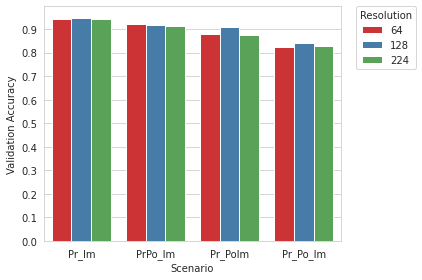

In [92]:
plotSummaryValidationAccuracy("bar", facet=False)

In [96]:
plotSummaryValidationAccuracy("box", facet=False)
#plotSummaryValidationAccuracy("point", facet=True)

NameError: name 'plotSummaryValidationAccuracy' is not defined

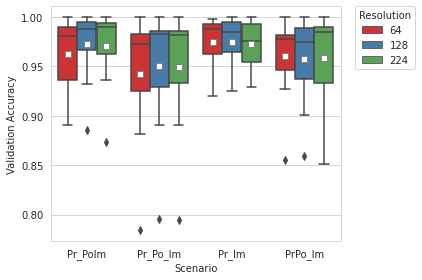

In [223]:
plotSummaryValidationAccuracy("box", facet=False)

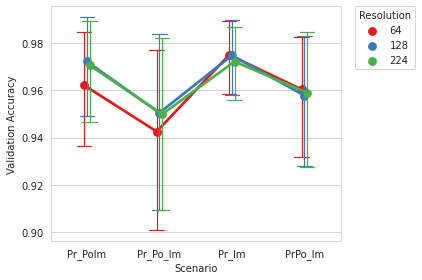

In [224]:
plotSummaryValidationAccuracy("point", facet=False)